In [1]:
import os
import pickle
import numpy as np
import string
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/bnaturebengali-image-captioning-dataset'
WORKING_DIR = '/kaggle/working'

In [3]:

model = VGG19()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

2022-06-18 05:07:00.463275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 05:07:00.557491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 05:07:00.558224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 05:07:00.559365: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

574726144/574710816 [==============================] - 15s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Pictures')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8000 [00:00<?, ?it/s]

2022-06-18 05:07:20.312935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-18 05:07:21.488913: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'caption','caption.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
captions_doc

'1.jpg   দুই শিশু গ্রামে হাঁটছে।\n1.jpg   একটা নীল জামা পড়া শিশু।\n1.jpg   দুই শিশু খেলা করে।\n1.jpg   দুইটা শিশু দাঁড়িয়ে আছে।\n2.jpg   কিছু লোক নদী পার করছে।\n2.jpg   কিছু লোক বিল পার করছে।\n2.jpg   অনেকগুলো লোক নদী পার করছে।\n2.jpg   জমির ভিতর অনেকগুলো লোক।\n2.jpg   কিছু লোক নদী পার করছে।\n3.jpg   এক কৃষক ক্ষেতে কাজ করছে।\n3.jpg   এক কৃষক ধান ক্ষেতে কাজ করছে।\n3.jpg   রোদ এর নিচে একটা লোক দাঁড়িয়ে আছে।\n3.jpg   এক কৃষক ধান দেখছে।\n3.jpg   শার্ট পড়া একটা লোক।\n4.jpg   কিছু শিশু তাদের স্কুল থেকে বাড়িতে যায়।\n4.jpg   কিছু শিশু ও একটি ভবন।\n4.jpg   ভবনে কিছু শিশু খেলা করে।\n4.jpg   সবুজ ধান ক্ষেত।\n4.jpg   স্কুলের জামা পড়া কিছু শিশু।\n5.jpg   পাঁচটি নারী এক জায়গায় চলছে।\n5.jpg   পাঁচটি শিশু এক জায়গায় চলছে।\n5.jpg   পাঁচটি মেয়ে খেলছে।\n5.jpg   হাসিমুখে পাঁচটি মেয়ে।\n5.jpg   পাঁচটি মেয়ে খেলতেছে।\n6.jpg   কিছু লোক পাহাড়ে বসে আছে।\n6.jpg   কিছু লোক বসে আছে।\n6.jpg   রোদ এর নিছে কিছু লোক বসে আছে।\n6.jpg   পাহারের উপর কিছু লোক বসে আছে।\n6.jpg   হাসিমুখে কিছু লোক বসে আছে।\n7.jpg   নদীর পা

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(' ')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/39106 [00:00<?, ?it/s]

In [10]:
len(mapping)

8000

In [11]:
mapping['6']

['  কিছু লোক পাহাড়ে বসে আছে।',
 '  কিছু লোক বসে আছে।',
 '  রোদ এর নিছে কিছু লোক বসে আছে।',
 '  পাহারের উপর কিছু লোক বসে আছে।',
 '  হাসিমুখে কিছু লোক বসে আছে।']

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('।', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
mapping['7']

['  নদীর পানিতে কিছু মানুষ।',
 '  বস্তা নিয়ে কিছু গ্রামের মানুষ নদী পার হয়।',
 '  অনেকগুলো গ্রামের মানুষ পানিতে।',
 '  কিছু ছেলে ও মেয়ে নদী পার হয়।',
 '  কিছু গ্রামের মানুষ নদী পার হয়ে যায়।']

In [14]:
clean(mapping)

In [15]:
mapping['7']

['startseq নদীর পানিতে কিছু মানুষ endseq',
 'startseq বস্তা নিয়ে কিছু গ্রামের মানুষ নদী পার হয় endseq',
 'startseq অনেকগুলো গ্রামের মানুষ পানিতে endseq',
 'startseq কিছু ছেলে মেয়ে নদী পার হয় endseq',
 'startseq কিছু গ্রামের মানুষ নদী পার হয়ে যায় endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

39104

In [18]:
all_captions[:10]

['startseq দুই শিশু গ্রামে হাঁটছে endseq',
 'startseq একটা নীল জামা পড়া শিশু endseq',
 'startseq দুই শিশু খেলা করে endseq',
 'startseq দুইটা শিশু দাঁড়িয়ে আছে endseq',
 'startseq কিছু লোক নদী পার করছে endseq',
 'startseq কিছু লোক বিল পার করছে endseq',
 'startseq অনেকগুলো লোক নদী পার করছে endseq',
 'startseq জমির ভিতর অনেকগুলো লোক endseq',
 'startseq কিছু লোক নদী পার করছে endseq',
 'startseq এক কৃষক ক্ষেতে কাজ করছে endseq']

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

9920

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

41

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

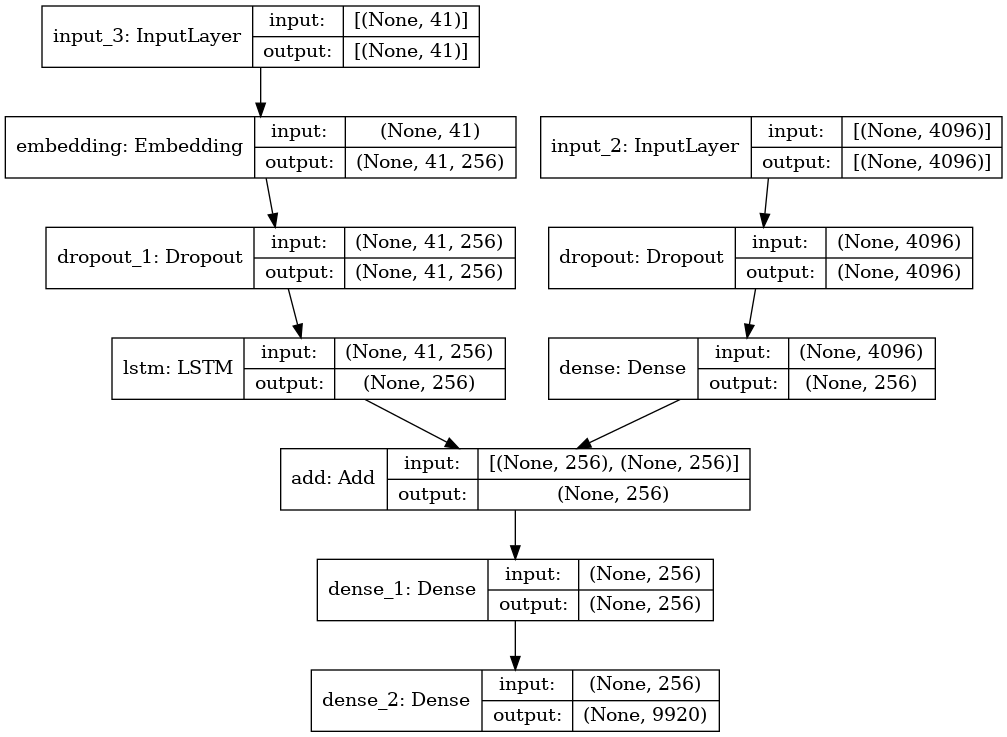

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
# train the model
epochs = 40
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

225/225 [==============================] - 62s 277ms/step - loss: 1.7953


In [26]:
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.448246
BLEU-2: 0.263905


In [30]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
   
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Pictures", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq দুইজন পুরুষ আছে endseq
startseq একটা বিল্ডিং তিনজন লোক বারান্দায় দাঁড়িয়ে কয়েকটা থালাবাসন নিয়ে কজ করছে endseq
startseq তিন জন মানুষ আছে endseq
startseq একজন পুরুষ লুঙ্গি পরে কাজ করছে দুইজন মানুষ হাতে একটি পাত্র নিয়ে কিছু দেখছে endseq
startseq একটি বাড়ির বারান্দায় তিন জন লোক কাজ করছে endseq
--------------------Predicted--------------------
startseq একটি বাড়ির গেট ধরে একজন মহিলা একসাথে বসে আছে endseq


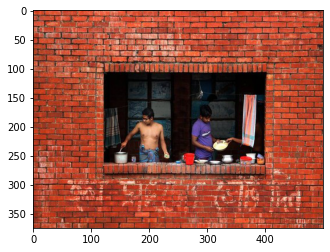

In [31]:
generate_caption("7021.jpg")

---------------------Actual---------------------
startseq অনেকগুলো মানুষ দাড়িয়ে আছে endseq
startseq কয়েকজন জেলে মিলে সমুদ্র থেকে মাছ ধরার জাল টেনে তুলছে endseq
startseq অনেক জন জেলে মাছ ধরার জাল টেনে তুলছে endseq
startseq সমুদ্র সৈকতে অনেক মানুষ কাজ করছে আর কিছু মানুষ হাটছে endseq
startseq ৫জন লোক একটি দড়ি ধরে দাড়িয়ে আছে endseq
--------------------Predicted--------------------
startseq কিছু মানুষ পরন্ত বিকালে নদীর পাড়ে দাড়িয়ে আছে কেউ কেউ ঝাপ দিচ্ছে endseq


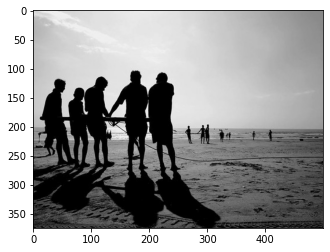

In [32]:
generate_caption("7071.jpg")